<a href="https://colab.research.google.com/github/AlexTeboul/msds/blob/main/csc594-topics-in-artificial-intelligence/CSC594_Emotional_Contagion_Content_Theory_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Alex Teboul

#CSC 594 - Emotionally Intelligent Chatbot

##Content Theory Implementation: Emotional Contagion

**Structured Outline Link: [Leveraging Emotional Contagion in Social Media Networks: Risks and Opportunities](https://docs.google.com/document/d/1ogNq4K2P4T7HVEK87tJAvS613AGk1N7jhonwYHgMxC8/edit?usp=sharing)**

**6 Emotional States**

For the purposes of this content theory, I only include the following base emotions. These help limit the scope of the emotional contagion content theory. 

* Joy
* Sadness
* Anger
* Fear
* Love
* Surprise

**3 Sentiment States**

As part of the content theory, there are also 3 sentiment states that can be infered from text. These help provide a baseline for interpretting the emotional state of users.
* Negative (-)
* Neutral
* Positive (+)

**Final Implementation Goals:**

*Emotional Contagion in Text*

1. Have a user input text about how they are feeling.
2. Classify the emotion in the speech or text.
3. Return the prediction of the user's emotional state in the form, "I sense that you are feeling ...[emotional state]."
4. Display 
5. From the classified emotions, display content that matches those emotions **or** displays content that is antagonistic to those emotions in an effort to alter the emotional state of the user. 
6. Do the same based on sentiment.
7. Ask the user's emotional state again and see if it has changed.
8. User emotional state will be transferred to the emotionally intelligent agent through this process. EIA emotional state may be transferred to user.
 

**Reference Notebooks:**

1.   Code Reference: [Deep Learning Based Emotion Recognition with TensorFlow](https://colab.research.google.com/drive/14I-31WuynLg1B0RQHWwwRgBmqTlDgkwV#scrollTo=ezRBSSehGFP_)







#1. Emotional States Model Building

**About this section:**

In this section, I attempt to build a train a model to recognize emotional states in text. I am using a process demonstrated by Elvis Saravia to use GRU RNN. The dataset used contains roughly 417k pre-processed tweets with associated joy, sadness, anger, fear, love, and surprise labels.


## 1. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Setup
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

import tensorflow as tf

## Get the Dataset

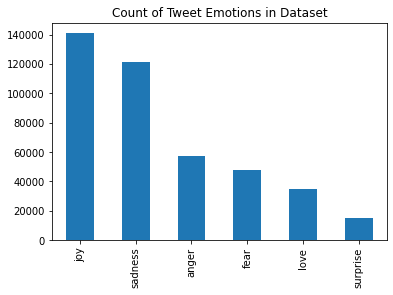

In [ ]:
# load data from tensorflow 
#https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/data/merged_training.pkl
data = load_from_pickle(directory="/content/gdrive/My Drive/Colab Notebooks/datasets/merged_training.pkl")

plt.title("Count of Tweet Emotions in Dataset")
data.emotions.value_counts().plot.bar()

In [ ]:
#count of emotions in dataset out of 416,809
#ex. there are 141,067 tweets containing the general emotion "joy" or something close to it.
data.emotions.value_counts()

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64

In [ ]:
#sample of the dataset
data.head(10)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


## Tokenization, Sampling, Vocabulary Construction, Index-Word Mapping

In [ ]:
# keep 80 tokens or less
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling 50k
data = data.sample(n=50000)

# see now we have 50k tweets only that are 80 tokens or less
data.shape

(50000, 3)

In [ ]:
# now we 
data.head() 

,text,emotions,token_size
74979,i just feel like it s just idiotic to say i m ...,sadness,27
67184,i feel that i don t have that many updates or ...,joy,22
28890,i wanted to go out to the strip club tonight b...,love,39
15531,i can go from feeling absolutely wonderful to ...,joy,15
12022,i can feel so beaten down by the sinful nature...,sadness,25


In [ ]:
# This class creates a word -> index mapping 
# ("think" -> 27) and vice-versa 
# (27 -> "think") across this dataset sample
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

## Put sample Data in Tensors

In [ ]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:20]

['a',
 'aa',
 'aaa',
 'aaaa',
 'aaaaaaaall',
 'aaaaall',
 'aaaahhhhhh',
 'aaah',
 'aaargh',
 'aaliyah',
 'aand',
 'aardvarkartglass',
 'aaron',
 'aarthi',
 'aatp',
 'ab',
 'abad',
 'abandoment',
 'abandon',
 'abandoned']

In [ ]:
# how many 'words' are in the vocabulary
len(inputs.vocab)

27505

In [ ]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [ ]:
input_tensor[0:2]

[[11713,
  13101,
  8794,
  13979,
  12711,
  20804,
  13101,
  11765,
  24650,
  21028,
  11713,
  14449,
  10201,
  24650,
  18482,
  20846,
  21513,
  3258,
  26588,
  19465,
  16853,
  10201,
  24650,
  26600,
  1,
  4854,
  11122],
 [11713,
  8794,
  24280,
  11713,
  7037,
  23889,
  10916,
  24280,
  14690,
  25848,
  16939,
  24377,
  24650,
  19486,
  16830,
  8206,
  5928,
  9332,
  657,
  24287,
  7430,
  17689]]

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

69


In [ ]:
# Padding the input and output tensor to the maximum length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                             maxlen=max_length_inp,
                                                             padding='post')

In [ ]:
#Show what it's like now that it's padded
input_tensor[0:2]

array([[11713, 13101,  8794, 13979, 12711, 20804, 13101, 11765, 24650,
        21028, 11713, 14449, 10201, 24650, 18482, 20846, 21513,  3258,
        26588, 19465, 16853, 10201, 24650, 26600,     1,  4854, 11122,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [11713,  8794, 24280, 11713,  7037, 23889, 10916, 24280, 14690,
        25848, 16939, 24377, 24650, 19486, 16830,  8206,  5928,  9332,
          657, 24287,  7430, 17689,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

## Binarization

In [ ]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [ ]:
# So that first row in the tensor here represents a tweet and it's corresponding emotion of sadness. 
target_tensor[0:2] 

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0]])

In [ ]:
# we now have a 6 dimensional tensor with our 60k sample tweet texts laid out by emotional state.
# Refer to why in the emotion_dict produced a few code blocks below
target_tensor.shape

(50000, 6)

## 6 Emotional States Dictionary

In [ ]:
data.head()

,text,emotions,token_size
74979,i just feel like it s just idiotic to say i m ...,sadness,27
67184,i feel that i don t have that many updates or ...,joy,22
28890,i wanted to go out to the strip club tonight b...,love,39
15531,i can go from feeling absolutely wonderful to ...,joy,15
12022,i can feel so beaten down by the sinful nature...,sadness,25


In [ ]:
get_emotion = lambda t: np.argmax(t)

In [ ]:
get_emotion(target_tensor[0])

4

In [ ]:
#Dictionary of 6 Emotional-States
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [ ]:
#This is the emotional state from that first entry in the target_tensor.
emotion_dict[get_emotion(target_tensor[0])]

'sadness'

## Training and Validation Set Splitting

Necessary to train the model

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

* We now 80-20 train test splits for NN to learn on. There's also a holdout for validation.

In [ ]:
# Data Loader Code

TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, 
                                                    target_tensor_train)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, 
                                                  target_tensor_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, 
                                                    target_tensor_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# checking minibatch
print(train_dataset)
print(val_dataset)
print(test_dataset)

<BatchDataset shapes: ((64, 69), (64, 6)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 69), (64, 6)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 69), (64, 6)), types: (tf.int32, tf.int64)>


## Build Model - Gated Recurrent Neural Network (GRU)

Now that the data is preprocessed and transformed, we can build the model. This particular model can uses a computation graph to train our emotion classifier. A recurrent neural network could also be used instead.

**Model Basic Architecture**
![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/gru-model.png?raw=true)

In [ ]:
### define the GRU component
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoGRU(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.gru = gru(self.hidden_units)
        self.fc = tf.keras.layers.Dense(output_size)
        
    def call(self, x, hidden):
        x = self.embedding(x) # batch_size X max_len X embedding_dim
        output, state = self.gru(x, initial_state = hidden) #  batch_size X max_len X hidden_units
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) # batch_size X max_len X output_size
        return out, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

In [ ]:
#test that it works
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)

# initialize the hidden state of the RNN
hidden = model.initialize_hidden_state()

# testing for the first batch only then break the for loop
# Potential bug: out is not randomized enough
for (batch, (inp, targ)) in enumerate(train_dataset):
    out, state = model(inp, hidden)
    print(out.shape) 
    break

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
(64, 6)


Train the GRU Model

In [ ]:
optimizer = tf.optimizers.Adam()

def loss_function(y, prediction):
    return tf.compat.v1.losses.softmax_cross_entropy(y, logits=prediction)

def accuracy(y, yhat):
    #compare the predictions to the truth
    yhat = tf.argmax(yhat, 1).numpy()
    y    = tf.argmax(y   , 1).numpy()
    return np.sum(y == yhat)/len(y)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    hidden = model.initialize_hidden_state()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ)) in enumerate(train_dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            predictions,_ = model(inp, hidden)
            loss += loss_function(targ, predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        batch_accuracy = accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        
        gradients = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradients, model.variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
            
    ### Validating
    hidden = model.initialize_hidden_state()

    for (batch, (inp, targ)) in enumerate(val_dataset):        
        predictions,_ = model(inp, hidden)        
        batch_accuracy = accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.2989
Epoch 1 Batch 100 Val. Loss 0.2596
Epoch 1 Batch 200 Val. Loss 0.2554
Epoch 1 Batch 300 Val. Loss 0.3029
Epoch 1 Batch 400 Val. Loss 0.2887
Epoch 1 Batch 500 Val. Loss 0.2612
Epoch 1 Batch 600 Val. Loss 0.2624
Epoch 1 Loss 0.2636 -- Train Acc. 0.3335 -- Val Acc. 0.3415
Time taken for 1 epoch 82.42999601364136 sec

Epoch 2 Batch 0 Val. Loss 0.2661
Epoch 2 Batch 100 Val. Loss 0.2501
Epoch 2 Batch 200 Val. Loss 0.2617
Epoch 2 Batch 300 Val. Loss 0.2598
Epoch 2 Batch 400 Val. Loss 0.2749
Epoch 2 Batch 500 Val. Loss 0.2568
Epoch 2 Batch 600 Val. Loss 0.2710
Epoch 2 Loss 0.2629 -- Train Acc. 0.3372 -- Val Acc. 0.3415
Time taken for 1 epoch 81.9231014251709 sec

Epoch 3 Batch 0 Val. Loss 0.2700
Epoch 3 Batch 100 Val. Loss 0.2711
Epoch 3 Batch 200 Val. Loss 0.2590
Epoch 3 Batch 300 Val. Loss 0.2826
Epoch 3 Batch 400 Val. Loss 0.2456
Epoch 3 Batch 500 Val. Loss 0.2541
Epoch 3 Batch 600 Val. Loss 0.3645
Epoch 3 Loss 0.2697 -- Train Acc. 0.3318 -- Val Acc. 0.2925


In [ ]:
model.summary()

Model: "emo_gru"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  7041536   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
cu_dnngru (CuDNNGRU)         multiple                  3938304   
_________________________________________________________________
dense (Dense)                multiple                  6150      
Total params: 10,985,990
Trainable params: 10,985,990
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

hidden = model.initialize_hidden_state()

for (batch, (inp, targ)) in enumerate(test_dataset):        
    predictions,_ = model(inp, hidden)        
    batch_accuracy = accuracy(targ, predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy/TEST_N_BATCH)

Test Accuracy:  0.9154647435897436


In [ ]:
#Save the model:
model.save_weights('emo_model')


In [ ]:
### Class to Properly Evaluate our Models
class Evaluate():

    def va_dist(cls, prediction, target, va_df, binarizer, name='', silent=False):
        """ Computes distance between actual and prediction through cosine distance """
        va_matrix = va_df.loc[binarizer.classes_][['valence','arousal']].values
        y_va = target.dot(va_matrix)
        F_va = prediction.dot(va_matrix)

        # dist is a one row vector with size of the test data passed(emotion)
        dist = metrics.pairwise.paired_cosine_distances(y_va, F_va)
        res = stats.describe(dist)

        # print by default (if silent=False)
        if not silent:
            print('%s\tmean: %f\tvariance: %f' % (name, res.mean, res.variance))

        return {
            'distances': dist,
            'dist_stat': res
        }

    def evaluate_class(cls, predictions, target, target2=None, silent=False):
        """ Compute only the predicted class """
        p_2_annotation = dict()

        precision_recall_fscore_support = [
            (pair[0], pair[1].mean()) for pair in zip(
                ['precision', 'recall', 'f1', 'support'],
                metrics.precision_recall_fscore_support(target, predictions)
            )
        ]

        metrics.precision_recall_fscore_support(target, predictions)

        # confusion matrix
        le = LabelEncoder()
        target_le = le.fit_transform(target)
        predictions_le = le.transform(predictions)
        cm = metrics.confusion_matrix(target_le, predictions_le)

        # prediction if two annotations are given on test data
        if target2:
            p_2_annotation = pd.DataFrame(
                [(pred, pred in set([t1,t2])) for pred, t1, t2 in zip(predictions, target, target2)],
                columns=['emo','success']
            ).groupby('emo').apply(lambda emo: emo.success.sum()/ len(emo.success)).to_dict()

        if not silent:
            print("Default Classification report")
            print(metrics.classification_report(target, predictions))

            # print if target2 was provided
            if len(p_2_annotation) > 0:
                print('\nPrecision on 2 annotations:')
                for emo in p_2_annotation:
                    print("%s: %.2f" % (emo, p_2_annotation[emo]))

            # print accuracies, precision, recall, and f1
            print('\nAccuracy:')
            print(metrics.accuracy_score(target, predictions))
            print("Correct Predictions: ", metrics.accuracy_score(target, predictions,normalize=False))
            for to_print in precision_recall_fscore_support[:3]:
                print( "%s: %.2f" % to_print )

            # normalizing the values of the consfusion matrix
            print('\nconfusion matrix\n %s' % cm)
            print('(row=expected, col=predicted)')
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cls.plot_confusion_matrix(cm_normalized, le.classes_, 'Confusion matrix Normalized')

        return {
            'precision_recall_fscore_support': precision_recall_fscore_support,
            'accuracy': metrics.accuracy_score(target, predictions),
            'p_2_annotation': p_2_annotation,
            'confusion_matrix': cm
        }

    def predict_class(cls, X_train, y_train, X_test, y_test,
                      pipeline, silent=False, target2=None):
        """ Predicted class,then run some performance evaluation """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        print("predictions computed....")
        return cls.evaluate_class(predictions, y_test, target2, silent)

    def evaluate_prob(cls, prediction, target_rank, target_class, binarizer, va_df, silent=False, target2=None):
        """ Evaluate through probability """
        # Run normal class evaluator
        predict_class = binarizer.classes_[prediction.argmax(axis=1)]
        class_eval = cls.evaluate_class(predict_class, target_class, target2, silent)

        if not silent:
            print('\n - First Emotion Classification Metrics -')
            print('\n - Multiple Emotion rank Metrics -')
            print('VA Cosine Distance')

        classes_dist = [
            (
                emo,
                cls.va_dist(
                    prediction[np.array(target_class) == emo],
                    target_rank[np.array(target_class) == emo],
                    va_df,
                    binarizer,
                    emo,
                    silent)
                ) for emo in binarizer.classes_
        ]
        avg_dist = cls.va_dist(prediction, target_rank, va_df, binarizer, 'avg', silent)

        coverage_error = metrics.coverage_error(target_rank, prediction)
        average_precision_score = metrics.average_precision_score(target_rank, prediction)
        label_ranking_average_precision_score = metrics.label_ranking_average_precision_score(target_rank, prediction)
        label_ranking_loss = metrics.label_ranking_loss(target_rank, prediction)

        # recall at 2
        # obtain top two predictions
        top2_pred = [set([binarizer.classes_[i[0]], binarizer.classes_[i[1]]]) for i in (prediction.argsort(axis=1).T[-2:].T)]
        recall_at_2 = pd.DataFrame(
            [
            t in p for t, p in zip(target_class, top2_pred)
            ], index=target_class, columns=['recall@2']).groupby(level=0).apply(lambda emo: emo.sum()/len(emo))

        # combine target into sets
        if target2:
            union_target = [set(t) for t in zip(target_class, target2)]
        else:
            union_target = [set(t) for t in zip(target_class)]

        # precision at k
        top_k_pred = [
            [set([binarizer.classes_[i] for i in i_list]) for i_list in (prediction.argsort(axis=1).T[-i:].T)]
            for i in range(2, len(binarizer.classes_)+1)]
        precision_at_k = [
            ('p@' + str(k+2), np.array([len(t & p)/(k+2) for t, p in zip(union_target, top_k_pred[k])]).mean())
            for k in range(len(top_k_pred))]

        # do this if silent= False
        if not silent:
            print('\n')
            print(recall_at_2)
            print('\n')
            print('p@k')
            for pk in precision_at_k:
                print(pk[0] + ':\t' + str(pk[1]))
            print('\ncoverage_error: %f' % coverage_error)
            print('average_precision_score: %f' % average_precision_score)
            print('label_ranking_average_precision_score: %f' % label_ranking_average_precision_score)
            print('label_ranking_loss: %f' % label_ranking_loss)

        return {
            'class_eval': class_eval,
            'recall_at_2': recall_at_2.to_dict(),
            'precision_at_2': precision_at_k,
            'classes_dist': classes_dist,
            'avg_dist': avg_dist,
            'coverage_error': coverage_error,
            'average_precision_score': average_precision_score,
            'label_ranking_average_precision_score': label_ranking_average_precision_score,
            'label_ranking_loss': label_ranking_loss
        }


    def predict_prob(cls, X_train, y_train, X_test, y_test, label_test, pipeline, binarizer, va_df, silent=False, target2=None):
        """ Output predcations based on training and labels """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict_proba(X_test)
        pred_to_mlb = [np.where(pipeline.classes_ == emo)[0][0] for emo in binarizer.classes_.tolist()]
        return cls.evaluate_prob(predictions[:,pred_to_mlb], y_test, label_test, binarizer, va_df, silent, target2)


    def plot_confusion_matrix(cls, cm, my_tags, title='Confusion matrix', cmap=plt.cm.Blues):
        """ Plotting the confusion_matrix"""
        plt.rc('figure', figsize=(4, 4), dpi=100)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(my_tags))
        target_names = my_tags
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
        # add normalized values inside the Confusion matrix
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

## results

Default Classification report
              precision    recall  f1-score   support

       anger       0.92      0.91      0.91       652
        fear       0.85      0.94      0.89       552
         joy       0.91      0.95      0.93      1690
        love       0.85      0.77      0.81       437
     sadness       0.97      0.93      0.95      1477
    surprise       0.87      0.74      0.80       184

    accuracy                           0.92      4992
   macro avg       0.89      0.87      0.88      4992
weighted avg       0.92      0.92      0.91      4992


Accuracy:
0.9154647435897436
Correct Predictions:  4570
precision: 0.89
recall: 0.87
f1: 0.88

confusion matrix
 [[ 595   24   14    1   17    1]
 [  12  517    3    0   11    9]
 [   6    6 1612   50    9    7]
 [   2    2   95  337    1    0]
 [  33   32   27    9 1373    3]
 [   1   29   16    0    2  136]]
(row=expected, col=predicted)


{'accuracy': 0.9154647435897436,
 'confusion_matrix': array([[ 595,   24,   14,    1,   17,    1],
        [  12,  517,    3,    0,   11,    9],
        [   6,    6, 1612,   50,    9,    7],
        [   2,    2,   95,  337,    1,    0],
        [  33,   32,   27,    9, 1373,    3],
        [   1,   29,   16,    0,    2,  136]]),
 'p_2_annotation': {},
 'precision_recall_fscore_support': [('precision', 0.8948282603155668),
  ('recall', 0.8738169212293075),
  ('f1', 0.8825755195916738),
  ('support', 832.0)]}

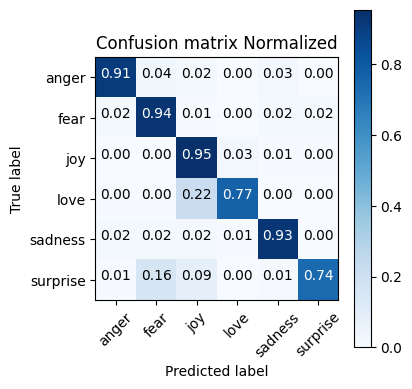

In [ ]:
evaluator = Evaluate()

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p)

predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion )

# 2. Sentiment States Model Building

###1. Get IMDB dataset which contains movie reviews data and preprocess it

In [ ]:
#Get the IMDB Dataset, format data appropriate to input into model
from keras.datasets import imdb
top_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)
#a total of 88000 words are contained in the dictionary and 
imdb.get_word_index()
word_dict_sent = imdb.get_word_index()
word_dict_sent = { key:(value + 3) for key, value in word_dict_sent.items() }
word_dict_sent[''] = 0  # Padding
word_dict_sent['>'] = 1 # Start
word_dict_sent['?'] = 2 # Unknown word
reverse_word_dict = { value:key for key, value in word_dict_sent.items() }
from keras.preprocessing import sequence
max_review_length = 500
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)
print(x_train.shape, x_test.shape)

Using TensorFlow backend.


(25000, 500) (25000, 500)


In [ ]:
import pandas as pd
dfff = pd.DataFrame(x_train)
dfff.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,22,21,134,476,26,480,5,144,30,5535,18,51,36,28,224,92,25,104,4,226,65,16,38,1334,88,12,16,283,5,16,4472,113,103,32,15,16,5345,19,178,32
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,152,491,18,2,32,7464,1212,14,9,6,371,78,22,625,64,1382,9,8,168,145,23,4,1690,15,16,4,1355,5,28,6,52,154,462,33,89,78,285,16,145,95
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,23,22,12,272,40,57,31,11,4,22,47,6,2307,51,9,170,23,595,116,595,1352,13,191,79,638,89,2,14,9,8,106,607,624,35,534,6,227,7,129,113
3,687,23,4,2,7339,6,3693,42,38,39,121,59,456,10,10,7,265,12,575,111,153,159,59,16,1447,21,25,586,482,39,4,96,59,716,12,4,172,65,9,579,...,14,31,9,242,955,48,25,279,2,23,12,1685,195,25,238,60,796,2,4,671,7,2804,5,4,559,154,888,7,726,50,26,49,7008,15,566,30,579,21,64,2574
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,74,233,334,207,126,224,12,562,298,2167,1272,7,2601,5,516,988,43,8,79,120,15,595,13,784,25,3171,18,165,170,143,19,14,5,7224,6,226,251,7,61,113


###2. Using a standard sequential model, relu activations, adam optimizer, and a binary crossentropy loss function

In [ ]:
#Building a model with keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

embedding_vector_length = 32
model_sent = Sequential()
model_sent.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_sent.add(Flatten())
model_sent.add(Dense(16, activation='relu'))
model_sent.add(Dense(16, activation='relu'))
model_sent.add(Dense(1, activation='sigmoid'))
model_sent.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model_sent.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                256016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 576,305
Trainable params: 576,305
Non-trainable params: 0
_________________________________________________________________
None


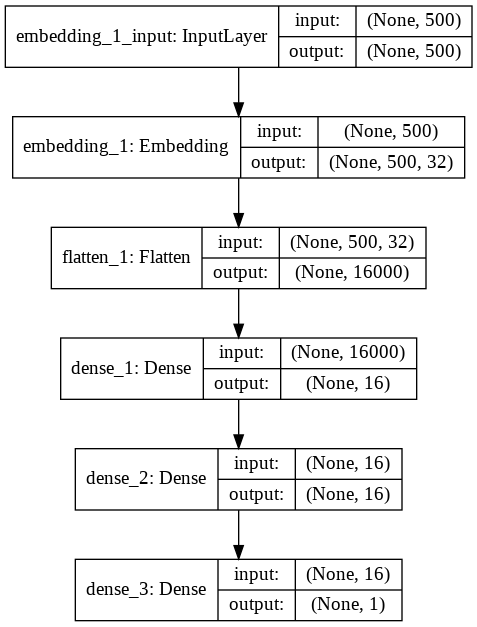

In [ ]:
# Output network visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
SVG(model_to_dot(model_sent).create(prog='dot', format='svg'))
plot_model(model_sent, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

###3. With a batch size of 128 and 5 epochs, train the model

In [ ]:
hist = model_sent.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=128)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 1s 51us/step - loss: 0.5654 - accuracy: 0.6471 - val_loss: 0.3150 - val_accuracy: 0.8627
Epoch 2/5
25000/25000 [==============================] - 1s 47us/step - loss: 0.2022 - accuracy: 0.9226 - val_loss: 0.2885 - val_accuracy: 0.8796
Epoch 3/5
25000/25000 [==============================] - 1s 47us/step - loss: 0.0602 - accuracy: 0.9838 - val_loss: 0.3520 - val_accuracy: 0.8735
Epoch 4/5
25000/25000 [==============================] - 1s 46us/step - loss: 0.0116 - accuracy: 0.9985 - val_loss: 0.4344 - val_accuracy: 0.8702
Epoch 5/5
25000/25000 [==============================] - 1s 46us/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.4793 - val_accuracy: 0.8701


###4. Display results of training

In [ ]:
scores = model_sent.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 87.01%


###5. Build an analyzer function to apply this outside model to our Yelp data

In [ ]:
#Build analyzer function based on the model to apply to the vegas dataset.
import string
import numpy as np

def analyzer(text):
    # Prepare the input by removing punctuation characters, converting
    # characters to lower case, and removing words containing numbers
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.lower().split(' ')
    text = [word for word in text if word.isalpha()]

    # Generate an input tensor
    input = [1]
    for word in text:
        if word in word_dict_sent and word_dict_sent[word] < top_words:
            input.append(word_dict_sent[word])
        else:
            input.append(2)
    padded_input = sequence.pad_sequences([input], maxlen=max_review_length)

    # Invoke the model and return the result
    result = model_sent.predict(np.array([padded_input][0]))[0][0]
    sentiment=''

    #how positive or negative
    if result > 0.66:
      sentiment = 'positive'
    elif result > 0.33:
      sentiment = 'neutral'
    else:
      sentiment = 'negative'
    return result, sentiment

###7. Test the model on some phrases

In [ ]:
analyzer('I love this class!')

(0.7927328, 'positive')

In [ ]:
analyzer('my day was okay. some good parts. fine')

(0.64419585, 'neutral')

In [ ]:
analyzer('my car broke down. i am so sad')

(0.124461584, 'negative')

## Implementation

1. A agent's sentiment state is initialized
2. A user tells the agent something. Can be good or bad. A story, how they're feeling, an idea, etc.
3. The agent interprets the sentiment of what it was told and its internal state moves in the direction of the overall sentiment of the user's input.


In [ ]:
import pandas as pd
import numpy as np
import ipywidgets as wg
from IPython.display import display
import random

In [ ]:
pd.set_option('display.max_colwidth', 240)

In [ ]:
data.head()

,text,emotions,token_size
74979,i just feel like it s just idiotic to say i m going to practice safe sex but we re only going to wear a condom here,sadness,27
67184,i feel that i don t have that many updates or things to read on every day for all the eager people,joy,22
28890,i wanted to go out to the strip club tonight because i wanted to see the stanley cup final game which was only on cable and im feeling horny and i wanted to see some tits in my face,love,39
15531,i can go from feeling absolutely wonderful to being overwhelmed by angry misery in seconds,joy,15
12022,i can feel so beaten down by the sinful nature and yet so clearly further along than i was even just a few years ago,sadness,25


In [ ]:
# positives
joy = data['emotions'] == "joy"
love = data['emotions'] == "love"
sadness = data['emotions'] == "sadness"

In [ ]:
# joy samples
data[joy].sample(n=5)

,text,emotions,token_size
133627,im feeling sweet and wholesome i want to slip into something more you know utilitarian a href https farm,joy,19
530,receiving my result slip pass on my birthday,joy,8
21647,i didnt feel clever or funny or grateful or sweet,joy,10
56789,i feel pretty fantastic about that,joy,6
8545,i am feeling very relieved and thankful that my mother sugary went so well she is having the other knee replaced over the next couple months so when both are done and she is ok i will feel very happy,joy,40


In [ ]:
# sadness samples
data[sadness].sample(n=5)

,text,emotions,token_size
119574,ive been feeling so rotten lately i just keep making the wrong decisions and i keep doing self destructive things,sadness,20
7115,i am hungover physically weak from going to the gym yesterday drinking a fair bit and being up until am and emotionally because sometimes after a big night out with a lot of people i feel quite lonely the next day,sadness,41
56662,i feel terrible for elizabeth fechtel,sadness,6
120071,ive been working hard and not getting enough sleep so im feeling a bit lethargic,sadness,15
35383,i feel i am truly myself does that seem tragic,sadness,10


In [ ]:
#
# Emotional Contagion Beta: Agent Takes on Sentiment of Others
#
import random
# game_running = True until someone quits
game_running = True
user_input='hello_world'

while game_running:
    # Greet the user to our game
    print()
    print("Hello and Welcome to the Emotional Contagion Game.  \n Enter q to exit the simulation \n Otherwise, tell the agent something (eg. something that happened to you, how you are feeling right now, a story, etc.) \n" )

    # *** The agent sentiment is randomly initialized between 0 and 1 ***
    agent1_init_sentiment = round(random.randint(0, 10)*.1,2)
    print("agent1_sentiment = ", agent1_init_sentiment)
    agent1_sentiment = agent1_init_sentiment

    # *** The agent's probability of emotional contagion is set (in this case, can't be 0)***
    #agent1_prob_emo_contagion = round(random.randint(1, 10)*.1,2)
    #print("agent1_prob_emo_contagion = ", agent1_prob_emo_contagion)

    # Get some sample statements with a particular sentiment
    agent_negative_sentiment_statements_list = ["Man today really sucks. I'm not feeling good.", 
                                                "I've just been so depressed lately. Hope this game makes me feel better.",
                                                "Ugh. What do you want. Can't you tell I'm not happy right now.",
                                                "Sigh, leave me alone. Today sucks.",
                                                "Just had a hard day at work. Hope your's was better."]
    agent_neutral_sentiment_statements_list = ["I feel pretty good today. Work was so so, but I'm fine.", 
                                               "Today was a bit of a bummer. But tonight should be fun.", 
                                               "I'm fine. How're you doing?", 
                                               "I'm feeling okay I suppose."]
    agent_positive_sentiment_statements_list = ["I feel pretty great today. Things are looking up.",
                                                "What a beautiful day, I'm feeling good.",
                                                "Today has been unusually good. I feel quite happy."
                                                ]

    # Get some sample statements to respond to an input 
    agent_negative_sentiment_responses_list = ["Well that stinks. I don't feel better after hearing that.", 
                                                "Awwh. Dang.",
                                                "That's too bad. Got me bummed out..",
                                                "Aye, my condolences.",
                                               "Ugh, sad..",
                                               "Give me some positive content. I'm not feeling good now...",
                                               "I'm not as happy now.. ",
                                               "What a bummer.."]
    agent_neutral_sentiment_responses_list = ["Well, that's not too rough. Good to know..", 
                                               "Don't know how to feel about that.", 
                                               "Hmmm. I'm feeling neutral about that.",
                                              "Okay then.. ",
                                              "Really didn't change my sentiment state at all.. Tell me something more EXTREME!"
                                                ]
    agent_positive_sentiment_responses_list = ["That's good news. I feel better.",
                                                "I'm feeling better after hearing that.",
                                                "Good stuff. Glad to hear it.."
                                                "Seem's positive to me. Tell me more!",
                                               "You know, after hearing that, I feel a little better.",
                                               "Need more of these positive vibes in my life. Thanks.",
                                               "Glad to hear it. Any more good news?"]


    #randomly 
    if agent1_sentiment < 0.33:
      print("agent1_init_state:", random.choice(agent_negative_sentiment_statements_list))
    elif agent1_sentiment < 0.66:
      print("agent1_init_state:", random.choice(agent_neutral_sentiment_statements_list))
    else:
      print("agent1_init_state:", random.choice(agent_positive_sentiment_statements_list))

    while user_input != "q":
      # Get the player's guess from the player
      print()
      user_input = input("Tell me something: ")

      # Does the user want to quit playing?
      if user_input == "q":
        game_running = False
        break

      #If the user has responded, update the sentiment of the agent with probability of contagion applied
      else:
        agent1_sentiment_analysis_of_user = analyzer(user_input)
        print("agent1_sentiment_analysis_of_user: ", agent1_sentiment_analysis_of_user) #Optionally hide this
        
        if agent1_sentiment_analysis_of_user[0] < 0.33:
          print("agent1_init_state:", random.choice(agent_negative_sentiment_responses_list))
          agent1_sentiment = (agent1_sentiment + agent1_sentiment_analysis_of_user[0]) / 2
          print("updated_agent1_sentiment: ", round(agent1_sentiment,2))

        elif agent1_sentiment_analysis_of_user[0] < 0.66:
          print("agent1_init_state:", random.choice(agent_neutral_sentiment_responses_list))
          #agent1_sentiment = (agent1_sentiment + agent1_sentiment_analysis_of_user[0]) / 2
          agent1_sentiment = agent1_sentiment
          print("updated_agent1_sentiment: ", round(agent1_sentiment,2))

        else:
          print("agent1_init_state:", random.choice(agent_positive_sentiment_responses_list))
          agent1_sentiment = (agent1_sentiment + agent1_sentiment_analysis_of_user[0]) / 2
          print("updated_agent1_sentiment: ", round(agent1_sentiment,2))

# Say goodbye to the player
print()
print("Thanks for playing Emotional Contagion Beta")


Hello and Welcome to the Emotional Contagion Game.  
 Enter q to exit the simulation 
 Otherwise, tell the agent something (eg. something that happened to you, how you are feeling right now, a story, etc.) 

agent1_sentiment =  0.1
agent1_init_state: I've just been so depressed lately. Hope this game makes me feel better.

Tell me something: you are beautiful
agent1_sentiment_analysis_of_user:  (0.8516507, 'positive')
agent1_init_state: Good stuff. Glad to hear it..Seem's positive to me. Tell me more!
updated_agent1_sentiment:  0.48

Tell me something: you suck
agent1_sentiment_analysis_of_user:  (0.73975855, 'positive')
agent1_init_state: I'm feeling better after hearing that.
updated_agent1_sentiment:  0.61

Tell me something: you have nice hair
agent1_sentiment_analysis_of_user:  (0.7414751, 'positive')
agent1_init_state: That's good news. I feel better.
updated_agent1_sentiment:  0.67

Tell me something: my leg is itchy
agent1_sentiment_analysis_of_user:  (0.56406534, 'neutral')
a